This notebook assesses the performance of the proposed method for recovering the weights in the analysis problem of GW-barycenters

Install and import packages

In [ ]:
# install Python OT
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
! pip install kagglehub

In [ ]:
import numpy as np # linear algebra
import cv2
import pandas as pd # data processing
import scipy as sp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import time

import kagglehub

import ot

In [ ]:
# Create an MDS instance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

We will use Point Cloud Mnist 2D for our experiments.

In [ ]:
path = kagglehub.dataset_download("cristiangarcia/pointcloudmnist2d",)

100%|██████████| 32.6M/32.6M [00:00<00:00, 65.8MB/s]


Extracting files...


In [ ]:
df = pd.read_csv(path+"/test.csv")
Data = df[df.columns[1:]].to_numpy()
label = df[df.columns[0]].to_numpy()
Data = Data.reshape(Data.shape[0], -1, 3)

In [ ]:
digit_indices = [np.where(label == digit)[0].tolist() for digit in range(10)]

The following function solves the GW-barycenter analysis problem.

In [ ]:
def get_lambdas(matrix_temp_list, measure_temp_list, matrix_input, mesaure_input):
  '''
  get_lambdas computes the barycentric weights (lambda_1,...,lamnda_S), where S is the number of templates,
  from the simplifyed GW-Barycenter Analysis Problem by using the Lagrange Multipliers approach
  and recontruct a matrix that is "close" to a barycentric matrix
  Input:
    matrix_temp_list: list of the template matrices, that is, a list of S arrays of different dimensions (Ns,Ns),
            each one represents an (Ns x Ns) matrix that is one of the S different dissimilarity matrices of the S templates
    measure_temp_list: list of S arrays of fifferent dimensions Ns,
            each one represents a probability vector in R^Ns that is one of the S probability measures of the S templates
    matrix_input: matrix representing a dissimilarity matrix you want to analyze: (M,M) array
    measure_input: probability vector of length M (array)
  Output:
  lambdas = vector of weights, as many as number of templates: S array
            it is not guaranteed lambdas[s] >=0
  matrix_output = new synthesize matrix

  '''
  S = len(matrix_temp_list)

  pi_list = []
  F_list = []

  Q = (mesaure_input.reshape(-1,1) @ mesaure_input.reshape(1,-1))
  Q = 1. / Q

  for s in range(S):
      pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input, measure_temp_list[s], mesaure_input)
      pi_list.append(pi_s)
      F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)
      F_list.append(F_s)

  K = np.zeros((S,S))
  b = np.zeros(S)
  for i in range(S):
      b[i] = np.trace(matrix_input @ F_list[i])
      for j in range(S):
          K[i,j] = np.trace(F_list[i] @ F_list[j])

  K_aug = np.hstack([K, -0.5 * np.ones(S).reshape(-1,1)])
  last_row = np.ones(K_aug.shape[1]).reshape(1,-1)
  last_row[0,-1] = 0
  K_aug = np.vstack([K_aug,last_row])

  b_aug = np.hstack([b, [1]])

  lambdas = np.linalg.solve(K_aug, b_aug)

  lambdas = lambdas[0:-1]

  matrix_output = np.zeros_like(matrix_input)

  for s in range(S):
    matrix_output += lambdas[s] * F_list[s]
    matrix_input = matrix_output

  return matrix_output, lambdas

Occlusion

In [ ]:
def occlusion(X,a):
  # Define occlusion box
  box_center = np.array([0.5, 0.5])  # Center of the occlusion
  box_size = np.array([0.3, 0.3])  # Width and height of the occlusion box
  box_min = box_center - box_size / 2
  box_max = box_center + box_size / 2

  # Mask points inside the box
  mask = (X[:, 0] < box_min[0]) | (X[:, 0] > box_max[0]) | (X[:, 1] < box_min[1]) | (X[:, 1] > box_max[1])

  # Apply mask to X and a
  X_occluded = X[mask]  # Keep only points outside the occlusion box
  a_occluded = a[mask]  # Remove mass inside the box

  # Renormalize `a` so it sums to 1
  a_occluded /= a_occluded.sum()

  return X_occluded, a_occluded

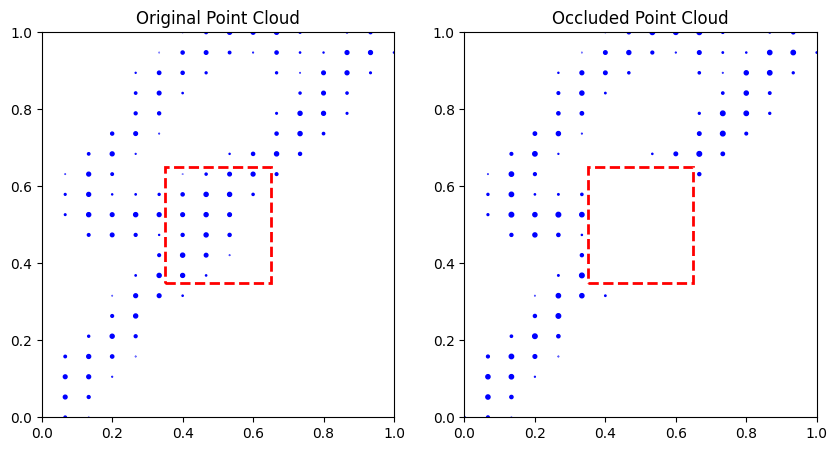

In [29]:
# Testing the occlusion in one sample of the data set

# Select a random sample
u = np.random.randint(0, 100)
a = Data[u, :, 2]  # Original mass values
X = Data[u, a != -1, :2]  # Extract valid points

# Normalize X
X = X - X.mean(0)[np.newaxis, :]
X -= X.min(axis=0)
X /= X.max(axis=0)

# Filter `a` (only keep valid entries)
a = a[a != -1]
a = a / float(a.sum())  # Normalize to sum to 1

# Define occlusion box
box_center = np.array([0.5, 0.5])  # Center of the occlusion
box_size = np.array([0.3, 0.3])  # Width and height of the occlusion box
box_min = box_center - box_size / 2
box_max = box_center + box_size / 2

# Mask points inside the box
mask = (X[:, 0] < box_min[0]) | (X[:, 0] > box_max[0]) | (X[:, 1] < box_min[1]) | (X[:, 1] > box_max[1])

# Apply mask to X and a
X_occluded, a_occluded = occlusion(X,a)


# Plot before and after occlusion
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X[:, 0], X[:, 1], s=a * 500, color='blue')
ax[0].set_title("Original Point Cloud")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[1].scatter(X_occluded[:, 0], X_occluded[:, 1], s=a_occluded * 500, color='blue')
ax[1].set_title("Occluded Point Cloud")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# Draw occlusion box
for a in ax:
    a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()

Get templates and is perturbations (occlusion.)

In [1]:
## Templates (matrix, measure)

digit = 3   # Pick a digit from 0 to 9

n_temp = 3   # Number of templates

ind_temp_list = []   #list of template indices from dataset
measure_temp_list = []   #list of template measures
matrix_temp_list = []   #list of template dissimilarity matrices
measure_occ_list = []   #list of template measures occluded
matrix_occ_list = []   #list of template dissimilarity matrices occluded


for s in range(n_temp):
    ind = digit_indices[digit][np.random.randint(len(digit_indices[digit]))]
    ind_temp_list.append(ind)

    p_s = Data[ind,:,2]
    valid_indices = np.where(p_s != -1)[0]
    p_s = p_s[valid_indices]
    p_s = p_s / float(p_s.sum())
    measure_temp_list.append(p_s)

    C_s = Data[ind, valid_indices, :2]
    C_s = C_s-C_s.mean(0)[np.newaxis,:]
    C_s -= C_s.min(axis=0)
    C_s /= C_s.max(axis=0)
    dist_matrix_s = sp.spatial.distance.cdist(C_s, C_s)
    matrix_temp_list.append(dist_matrix_s)

    # Apply mask to C_s and p_s
    C_occluded, p_occluded = occlusion(C_s,p_s)
    measure_occ_list.append(p_occluded)
    dist_matrix_occ = sp.spatial.distance.cdist(C_occluded, C_occluded)
    matrix_occ_list.append(dist_matrix_occ)

NameError: name 'digit_indices' is not defined

Generate vector of weights of your barycenter.


In [31]:
lambdas_list = np.random.rand(n_temp)
lambdas_list = lambdas_list/lambdas_list.sum()

Synthesize a Barycenter using POT.

In [43]:
M = 100 # Dimension of output barycentric matrix is MxM.

#b = np.ones(M) / M   # Uniform target probability vector
b = np.random.rand(M)
b = b/b.sum()   # Random target probability vector

B =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas_list)  # Synthesize barycenter matrix
B = (B + B.T) / 2   # sym

points_B = mds.fit_transform(B)
points_B = points_B-points_B.mean(0)[np.newaxis,:]
points_B -= points_B.min(axis=0)
points_B /= points_B.max(axis=0)

Synthesize a perturbed Barycenter using POT.

In [44]:
## Option 1

B1, b1 = occlusion(points_B,b)
B1 = dist_matrix_occ = sp.spatial.distance.cdist(B1, B1)

In [45]:
## Option 2

M2 = 80 # Dimension of output barycentric matrix is MxM.

#b = np.ones(M) / M   # Uniform target probability vector
b2 = np.random.rand(M2)
b2 = b2/b2.sum()   # Random target probability vector

B2 =  ot.gromov.gromov_barycenters(M2, matrix_occ_list, measure_occ_list, b2, lambdas_list)  # Synthesize barycenter matrix
B2 = (B2 + B2.T) / 2   # sym


In [46]:
_, lambdas1 = get_lambdas(matrix_occ_list, measure_occ_list, B1, b1)
_, lambdas2 = get_lambdas(matrix_occ_list, measure_occ_list, B2, b2)

B_recon1 =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas1)
B_recon1 = (B_recon1 + B_recon1.T) / 2   # sym

B_recon2 =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas2)
B_recon2 = (B_recon2 + B_recon2.T) / 2   # sym

print('Lambdas Error = ', np.linalg.norm(lambdas_list - lambdas1, 1))
print('Lambdas Error = ', np.linalg.norm(lambdas_list - lambdas2, 1))

## Compare Original target vs reconstruction
gromov_distance = ot.gromov.gromov_wasserstein(B,B_recon1,b,b, log=True)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW(Target,Reconstructed Target): {gw_dist}')

gromov_distance = ot.gromov.gromov_wasserstein(B,B_recon2,b,b, log=True)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW(Target,Reconstructed Target): {gw_dist}')

Lambdas Error =  0.957466934043061
Lambdas Error =  2.2419566203524255e-14
GW(Target,Reconstructed Target): 0.0031701193610042034
GW(Target,Reconstructed Target): 0.0016222240790903825


Visualize by using MDS embedding

In [47]:
## Fit and transform the distance matrix
points_B2 = mds.fit_transform(B2)
points_B2 = points_B2-points_B2.mean(0)[np.newaxis,:]
points_B2 -= points_B2.min(axis=0)
points_B2 /= points_B2.max(axis=0)

points_B_recon = mds.fit_transform(B_recon2)
points_B_recon = points_B_recon-points_B_recon.mean(0)[np.newaxis,:]
points_B_recon -= points_B_recon.min(axis=0)
points_B_recon /= points_B_recon.max(axis=0)

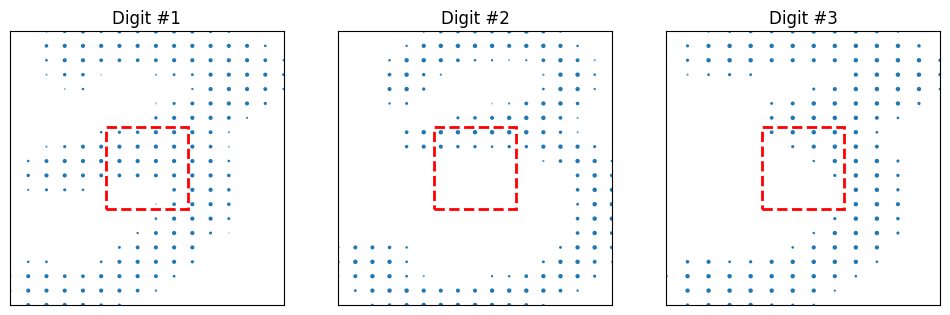

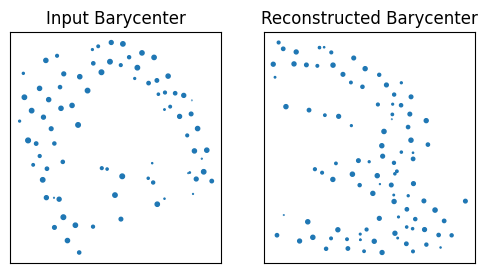

In [59]:
## Plot templates
fig, axes = plt.subplots(1, n_temp, figsize=(12, 6))
axes = axes.flatten()

for i, ind in enumerate(ind_temp_list):
    a = Data[ind,:,2]
    X = Data[ind,a!=-1,:2]
    X = X-X.mean(0)[np.newaxis,:]
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    a = a[a!=-1]
    a = a/float(a.sum())
    axes[i].scatter(X[:, 0], X[:, 1], s=a*500)
    axes[i].set_title(f'Digit #{i+1}')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    #axes[i].axis('off')

# Draw occlusion box
for a in axes:
    a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()


## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].scatter(-points_B2[:, 0], points_B2[:, 1], s=b2*500)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks

axes[1].scatter(-points_B_recon[:, 0], points_B_recon[:, 1], s=b*500)
axes[1].set_title('Reconstructed Barycenter')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks



plt.show()



In [49]:
# Option 1

points_B1 = mds.fit_transform(B1)
points_B1 = points_B1-points_B1.mean(0)[np.newaxis,:]
points_B1 -= points_B1.min(axis=0)
points_B1 /= points_B1.max(axis=0)

points_B_recon = mds.fit_transform(B_recon1)
points_B_recon = points_B_recon-points_B_recon.mean(0)[np.newaxis,:]
points_B_recon -= points_B_recon.min(axis=0)
points_B_recon /= points_B_recon.max(axis=0)

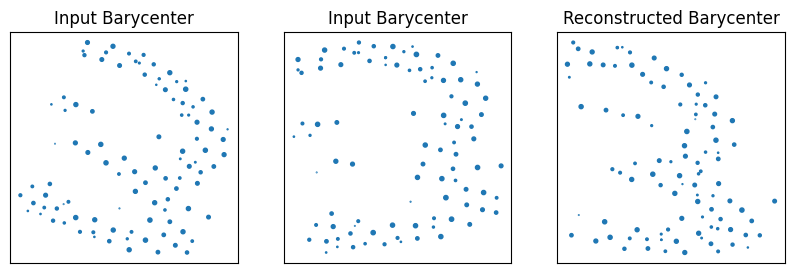

In [64]:
## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(-points_B[:, 0], points_B[:, 1], s=b*500)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks


axes[1].scatter(points_B1[:, 0], -points_B1[:, 1], s=b1*500)
axes[1].set_title('Input Barycenter')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

axes[2].scatter(-points_B_recon[:, 0], points_B_recon[:, 1], s=b*500)
axes[2].set_title('Reconstructed Barycenter')
axes[2].set_xticks([])  # Remove x-axis ticks
axes[2].set_yticks([])  # Remove y-axis ticks

# Draw occlusion box
# for a in axes:
#     a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()



